In [3]:
import os
import glob
import random

In [4]:
import torch
import torchvision
import torchvision.transforms as transforms

In [6]:
ROOT = os.path.join(os.getcwd(),'img')
img_folders = {
    'clown':os.path.join(ROOT,'clown'),
    'reef':os.path.join(ROOT,'reef')
}

# Image cleaning

In [11]:
import string
import random

def random_string(min_char=8,max_char=None):
    if max_char is None:
        max_char = min_char
    allchar = string.ascii_letters + string.digits
    return "".join(random.choice(allchar) for x in range(random.randint(min_char, max_char)))

In [28]:
import uuid
uuid.uuid4().hex

'03b0d27fbabc4170b98f149771851528'

In [29]:
import os
import time

def rename(folder,new_name,start=1,prefix='',suffix=''):
    temp = random_string()
    # Use temp name first to avoid overwriting
    for k,img in enumerate(os.listdir(folder),start):
        os.rename(
            '{f}/{i}'.format(f=folder,i=img),
            '{f}/{t}{k:03d}'.format(f=folder,t=temp,k=k)
        )
        time.sleep(0.01)

    for k,img in enumerate(os.listdir(folder),start):
        os.rename(
            '{f}/{i}'.format(f=folder,i=img),
            '{f}/{p}{n}{k:03d}{s}'.format(f=folder,p=prefix,n=new_name,k=k,s=suffix)
        )
        time.sleep(0.01)

In [43]:
rename(img_folders['clown'],'clown',suffix='.png')

In [44]:
rename(img_folders['reef'],'reef',suffix='.png')

# Resize image

In [37]:
from PIL import Image

In [38]:
def custom_resize(img,max_size=600):
    (width, height) = img.size
    RATIO = min(min(max_size/width,1),min(max_size/height,1))
    new_size = (int(width*RATIO),int(height*RATIO))
    img = img.resize(new_size)
    return img

In [39]:
def resize(img_path,output_path=None,max_size=600):
    if output_path is None:
        output_path = img_path
    original_image = Image.open(img_path)
    new_image = custom_resize(original_image,max_size)
    new_image.save(output_path)

In [42]:
path = img_folders['clown']
for img in os.listdir(path):
    try:
        resize(path+'/'+img)
    except:
        print(img)

clown056.png


# Image to 3D matrices

It has been shown that RGB is better suited than other color spaces for common applications. So we will stick to RGB

In [200]:
import numpy as np
import scipy

In [208]:
def normalized_image(img_path):
    return scipy.misc.imread(img_path)/255

example = normalized_image('/Users/Alex/Google Drive/GitHub/FishNet/img/clown/clown001.png')

# Define network

In [213]:
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

In [241]:
class FishNet(nn.Module):
    def __init__(self,number_classes=10):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.apool = nn.AdaptiveAvgPool2d(16)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, number_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.apool(x)
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


mynet = FishNet(2)
mynet

FishNet (
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (apool): AdaptiveAvgPool2d (output_size=16)
  (fc1): Linear (400 -> 120)
  (fc2): Linear (120 -> 84)
  (fc3): Linear (84 -> 2)
)

# All in one loading and preprocessing

In [226]:
from torchvision import transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader

In [333]:
def my_collate(batch):
    data = [item[0] for item in batch]
    target = [item[1] for item in batch]
    target = torch.LongTensor(target)
    return [data, target]


train_transforms = transforms.Compose([transforms.Scale(size = 224),
                                       transforms.ToTensor(),
                                       ])

# change root to valid dir in your system, see ImageFolder documentation for more info
train_dataset = datasets.ImageFolder(root=ROOT,
                                    transform=train_transforms)

trainset = DataLoader(dataset=train_dataset,
                      batch_size=8,
                      shuffle=True,
                      collate_fn=my_collate # use custom collate function here
                      )

trainiter = iter(trainset)
imgs, labels = trainiter.next()

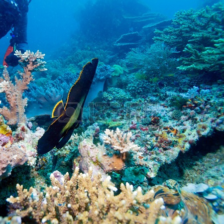

In [340]:
example = imgs[1]
transforms.ToPILImage()(example)